# GNN Benchmarking for Stock Return Prediction
**2025-10-06**

In [ ]:
!pip install -q nodevectors==0.2.0
!pip install -q networkx==3.5.0
!pip install -q torch-geometric==2.5.3
#!pip install -q torch-geometric-temporal==0.56.2

# 1) Imports, config, seeds



In [12]:
import warnings, math, random, gc
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import yfinance as yf
import networkx as nx

from nodevectors import Node2Vec


from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as PyGDataLoader
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, GINConv

#from torch_geometric_temporal.nn.recurrent import EvolveGCNO



# ---------------- CONFIG ----------------
CONFIG = {
  "tickers": [
      # Tech
      "AAPL","MSFT","GOOGL","NVDA","META",
      # Finance
      "JPM","BAC","GS","V","MA",
      # Consumer
      "WMT","COST","DIS","KO","PEP",
      # Healthcare
      "PFE","UNH","JNJ",
      # Energy
      "XOM","CVX",
      # Industrials / Others
      "CAT","HD","MCD","NKE","ORCL","IBM","TXN","INTC","AMZN"
  ],
  "start": "2005-01-01",
  "end":   "2025-01-01",

  # target horizon
  "horizon_days": 5,          # predict next-week up/down

  # graph
  "corr_window": 60,
  "corr_thr": 0.4,

  # splits
  "train_end": "2019-12-31",
  "val_end":   "2020-12-31",

  # eval
  "top_k_frac": 0.10,         # dynamic P@K = 10% per day
  "top_k_abs":  None,

  # models / training
  "epochs_gnn": 15,
  "epochs_lstm": 10,
  "seq_len": 30,
  "hidden_gnn": 64,
  "hidden_lstm": 64,
  "lr": 1e-3,
  "weight_decay": 1e-4,
  "seed": 42
}

SEED = CONFIG["seed"]
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

# 2) Data download & core features (shared)

In [13]:
import yfinance as yf

# ---------- prices ----------
data = yf.download(CONFIG["tickers"], start=CONFIG["start"], end=CONFIG["end"], auto_adjust=True, progress=False)
prices = data["Close"].dropna(how="all")
prices = prices.dropna(axis=1, how="any")
tickers_used = sorted(prices.columns.tolist())
print("Tickers:", len(tickers_used))

# ---------- feature helpers ----------
def compute_returns(prices: pd.DataFrame, lag=1): return prices.pct_change(lag)
def rolling_volatility(returns: pd.DataFrame, window=20): return returns.rolling(window).std()

spy = yf.download("^GSPC", start=CONFIG["start"], end=CONFIG["end"], auto_adjust=True, progress=False)['Close']
spy_ret = spy.pct_change(1)

def rolling_beta(stock_returns: pd.DataFrame, market_returns: pd.Series, window=60):
    cov = stock_returns.rolling(window).cov(market_returns)
    var = market_returns.rolling(window).var()
    return cov.div(var, axis=0)

# ---------- raw features ----------
rets_1d  = compute_returns(prices, 1)
rets_5d  = compute_returns(prices, 5)
rets_21d = compute_returns(prices, 21)
vol_20d  = rolling_volatility(rets_1d, 20)
beta_60d = rolling_beta(rets_1d, spy_ret, 60)
mom_5d   = prices.pct_change(5)  # simple momentum proxy

# ---------- label: next-week up/down ----------
H = CONFIG["horizon_days"]
label_h = (compute_returns(prices, H).shift(-1) > 0).astype(int)

# ---------- stack to (date, ticker) ----------
def stack_features(feat_df, name):
    s = feat_df.stack().rename(name).to_frame()
    s.index.set_names(['date','ticker'], inplace=True)
    return s

feat_frames = []
for name, df in {
    "ret_1d": rets_1d,
    "ret_5d": rets_5d,
    "ret_21d": rets_21d,
    "vol_20d": vol_20d,
    "beta_60d": beta_60d,
    "mom_5d":  mom_5d
}.items():
    f = stack_features(df, name)
    feat_frames.append(f)

X = pd.concat(feat_frames, axis=1).dropna(how="all").fillna(0)
y = stack_features(label_h, "label").reindex(X.index).dropna()
X = X.loc[y.index]

# Cross-sectional z-score per day
X_z = X.groupby(level='date').transform(lambda col: (col - col.mean())/(col.std(ddof=0)+1e-9))

# drop early history to stabilize rolling stats
MIN_HISTORY = max(CONFIG["corr_window"], 80)
valid_dates = prices.index[MIN_HISTORY:]
X_z = X_z.loc[X_z.index.get_level_values('date').isin(valid_dates)]
y   = y.loc[X_z.index]

print("Final shapes:", X_z.shape, y.shape)


Tickers: 26
Final shapes: (128778, 6) (128778, 1)


# 3) Split by time (no leakage)

In [14]:
dates = X_z.index.get_level_values('date')
train_mask = dates <= pd.to_datetime(CONFIG["train_end"])
val_mask   = (dates > pd.to_datetime(CONFIG["train_end"])) & (dates <= pd.to_datetime(CONFIG["val_end"]))
test_mask  = dates > pd.to_datetime(CONFIG["val_end"])

X_train, y_train = X_z[train_mask], y[train_mask]
X_val,   y_val   = X_z[val_mask],   y[val_mask]
X_test,  y_test  = X_z[test_mask],  y[test_mask]

len(X_train), len(X_val), len(X_test)


(96070, 6578, 26130)

# 4) Evaluation helpers (robust, dynamic P@K)

In [15]:
TOP_K_FRAC = CONFIG["top_k_frac"]
TOP_K_ABS  = CONFIG["top_k_abs"]

def _resolve_k(n):
    if TOP_K_ABS is not None: k = TOP_K_ABS
    elif TOP_K_FRAC is not None: k = max(1, int(round(TOP_K_FRAC*n)))
    else: k = max(1, int(round(0.1*n)))
    return min(k, max(1,n))

def precision_at_k(scores: np.ndarray, labels: np.ndarray, k: int) -> float:
    mask = ~np.isnan(scores) & ~np.isnan(labels)
    s = scores[mask].astype(float); y = labels[mask].astype(int)
    n = len(s); k = min(max(1,k), n)
    if n == 0 or k == 0: return np.nan
    idx = np.argsort(-s, kind="mergesort")[:k]
    return float(np.mean(y[idx]))

def daily_metric_aggregate(df_scores: pd.DataFrame) -> pd.Series:
    rows = []
    for d, sub in df_scores.groupby('date'):
        y = sub['label'].to_numpy()
        s = sub['score'].to_numpy()
        y_hat = (s >= 0.5).astype(int)
        acc = accuracy_score(y, y_hat) if len(np.unique(y))>=1 else np.nan
        auc = roc_auc_score(y, s) if len(np.unique(y))>1 else np.nan
        f1  = f1_score(y, y_hat)  if len(np.unique(y))>1 else np.nan
        k   = _resolve_k(len(sub))
        p_at_k = precision_at_k(s, y, k)
        rows.append((d, acc, auc, f1, p_at_k))
    out = pd.DataFrame(rows, columns=['date','acc','auc','f1','p_at_k']).set_index('date')
    return out.mean(skipna=True)


# 5) Tabular baselines (LogReg, XGBoost)

In [16]:
def evaluate_tabular_model(model, X_df, y_arr):
    dates = X_df.index.get_level_values("date")
    scores = model.predict_proba(X_df.values)[:,1]
    tmp = pd.DataFrame({"date": dates.values, "score": scores, "label": y_arr.astype(float)})
    return daily_metric_aggregate(tmp)

# Logistic Regression
lr = LogisticRegression(max_iter=2000, solver='saga', penalty='l2', n_jobs=-1)
lr.fit(X_train.values, y_train.values.ravel())
lr_test = evaluate_tabular_model(lr, X_test, y_test.values.ravel())

# XGBoost
xgb = XGBClassifier(
    n_estimators=300, max_depth=5, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.8, reg_lambda=1.0,
    tree_method='hist', random_state=SEED
)
xgb.fit(X_train.values, y_train.values.ravel(),
        eval_set=[(X_val.values, y_val.values.ravel())],
        verbose=False)
xgb_test = evaluate_tabular_model(xgb, X_test, y_test.values.ravel())

print("LogReg TEST:\n", lr_test)
print("XGBoost TEST:\n", xgb_test)


LogReg TEST:
 acc       0.724914
auc       0.892359
f1        0.736651
p_at_k    0.905473
dtype: float64
XGBoost TEST:
 acc       0.723574
auc       0.880352
f1        0.736750
p_at_k    0.893864
dtype: float64


# 6) LSTM (shared model across stocks)

In [17]:
# Build per-stock sequences: (seq_len, feat_dim) -> label (next-week up/down)
SEQ_LEN = CONFIG["seq_len"]

# Prepare panel (date x ticker x features)
panel = X_z.reset_index().pivot(index='date', columns='ticker', values=X_z.columns.tolist())
# panel has MultiIndex columns (feature, ticker) or vice versa. We'll reformat:

# Easier: build sequences ticker-by-ticker
feat_cols = X_z.columns.tolist()
def build_lstm_samples(X_df, y_df, tickers, seq_len):
    X_out, y_out = [], []
    by_t = {t: X_df.xs(t, level='ticker') for t in tickers}       # per-ticker feature frame (date-index)
    y_by_t = {t: y_df.xs(t, level='ticker') for t in tickers}     # per-ticker labels
    for t in tickers:
        X_t = by_t[t].sort_index()
        y_t = y_by_t[t].sort_index().reindex(X_t.index).dropna()
        # align
        X_t = X_t.reindex(y_t.index)
        arr = X_t.to_numpy(dtype=np.float32)
        lab = y_t['label'].to_numpy(dtype=np.float32)
        for i in range(len(arr) - seq_len):
            X_out.append(arr[i:i+seq_len, :])
            y_out.append(lab[i+seq_len])
    return np.stack(X_out), np.array(y_out)

Xtr_seq, ytr_seq = build_lstm_samples(X_train, y_train, tickers_used, SEQ_LEN)
Xva_seq, yva_seq = build_lstm_samples(X_val,   y_val,   tickers_used, SEQ_LEN)
Xte_seq, yte_seq = build_lstm_samples(X_test,  y_test,  tickers_used, SEQ_LEN)
Xtr_seq.shape, Xva_seq.shape, Xte_seq.shape

class LSTMCls(nn.Module):
    def __init__(self, in_dim, hid=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size=in_dim, hidden_size=hid, batch_first=True)
        self.lin  = nn.Linear(hid, 1)
    def forward(self, x):
        # x: (B, T, F)
        out, _ = self.lstm(x)
        h = out[:, -1, :]
        logit = self.lin(h)
        return logit.squeeze(-1)

def train_lstm(Xtr, ytr, Xva, yva, epochs=10, lr=1e-3):
    model = LSTMCls(in_dim=Xtr.shape[-1], hid=CONFIG["hidden_lstm"]).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    bce = nn.BCEWithLogitsLoss()
    def to_batches(X, y, bs=256):
        for i in range(0, len(X), bs):
            yield torch.tensor(X[i:i+bs]).to(DEVICE), torch.tensor(y[i:i+bs]).float().to(DEVICE)
    for ep in range(1, epochs+1):
        model.train(); tot=0
        for xb, yb in to_batches(Xtr, ytr):
            opt.zero_grad()
            logit = model(xb)
            loss = bce(logit, yb)
            loss.backward(); opt.step(); tot += loss.item()
        # simple val
        model.eval()
        with torch.no_grad():
            val_logits = []
            for xb, yb in to_batches(Xva, yva):
                val_logits.append(model(xb).detach().cpu().numpy())
            val_logits = np.concatenate(val_logits) if len(val_logits)>0 else np.array([])
            val_probs  = 1/(1+np.exp(-val_logits))
            val_pred   = (val_probs>=0.5).astype(int)
            val_acc    = (val_pred == yva[:len(val_pred)]).mean() if len(val_pred)>0 else np.nan
        print(f"Epoch {ep:02d} LSTM train_loss={tot/max(1,len(Xtr)):.4f} val_acc={val_acc:.3f}")
    return model

lstm_model = train_lstm(Xtr_seq, ytr_seq, Xva_seq, yva_seq, epochs=CONFIG["epochs_lstm"], lr=CONFIG["lr"])

# Evaluate LSTM cross-sectionally (approximate): use test sequences → map each sequence end date to a date bin.
# For simplicity we compute overall metrics on test sequences (sufficient for comparison).
with torch.no_grad():
    xb = torch.tensor(Xte_seq).to(DEVICE)
    logits = lstm_model(xb).detach().cpu().numpy()
probs = 1/(1+np.exp(-logits))
yhat  = (probs>=0.5).astype(int)
lstm_acc = (yhat == yte_seq[:len(yhat)]).mean()
# AUC/F1 on sequence-level (not per-day). This is a complementary view for LSTM.
from sklearn.metrics import roc_auc_score, f1_score
try: lstm_auc = roc_auc_score(yte_seq[:len(yhat)], probs)
except: lstm_auc = np.nan
lstm_f1  = f1_score(yte_seq[:len(yhat)], yhat) if len(np.unique(yte_seq))>1 else np.nan
print(f"LSTM TEST (sequence-level): acc={lstm_acc:.3f} auc={lstm_auc:.3f} f1={lstm_f1:.3f}")


Epoch 01 LSTM train_loss=0.0024 val_acc=0.672
Epoch 02 LSTM train_loss=0.0023 val_acc=0.679
Epoch 03 LSTM train_loss=0.0023 val_acc=0.674
Epoch 04 LSTM train_loss=0.0023 val_acc=0.676
Epoch 05 LSTM train_loss=0.0023 val_acc=0.677
Epoch 06 LSTM train_loss=0.0022 val_acc=0.676
Epoch 07 LSTM train_loss=0.0022 val_acc=0.677
Epoch 08 LSTM train_loss=0.0022 val_acc=0.678
Epoch 09 LSTM train_loss=0.0022 val_acc=0.678
Epoch 10 LSTM train_loss=0.0022 val_acc=0.678
LSTM TEST (sequence-level): acc=0.705 auc=0.779 f1=0.753


# 7) Graphs: correlation snapshots (GNN) + static train-corr (Node2Vec)

In [18]:
# Correlation snapshots for GNNs (per-day)
returns_1d = prices.pct_change(1)
def build_edge_index_for_day(day, corr_w=CONFIG["corr_window"], thr=CONFIG["corr_thr"]):
    if day not in returns_1d.index: return None
    end_loc = returns_1d.index.get_loc(day)
    if end_loc < corr_w: return None
    window = returns_1d.iloc[end_loc-corr_w+1:end_loc+1][tickers_used]

    # Choose edge-building method
    use_graphical_lasso = False
    use_var = False

    if use_graphical_lasso:
        from sklearn.covariance import GraphicalLasso
        model = GraphicalLasso(alpha=0.01).fit(window.fillna(0))
        prec = model.precision_
        mat = -prec / np.max(np.abs(prec))
    elif use_var:
        from statsmodels.tsa.api import VAR
        model = VAR(window.fillna(0)).fit(maxlags=3)
        mat = model.coefs_.mean(axis=0)
    else:
        mat = window.corr().fillna(0.0).values

    edges = []
    for i in range(len(tickers_used)):
        for j in range(i+1, len(tickers_used)):
            if abs(mat[i,j]) >= thr:
                edges.append([i,j]); edges.append([j,i])

    if not edges: return None
    return torch.tensor(edges, dtype=torch.long).t().contiguous()

def build_day_tensor(day, X_day, y_day):
    x = torch.tensor(X_day.loc[(day,)].reindex(tickers_used).values, dtype=torch.float32)
    y = torch.tensor(y_day.loc[(day,)].reindex(tickers_used).values.astype(int), dtype=torch.long).view(-1)
    edge_index = build_edge_index_for_day(day)
    if edge_index is None: return None
    return Data(x=x, edge_index=edge_index, y=y)

all_days = sorted(X_z.index.get_level_values('date').unique())
train_days = [d for d in all_days if d <= pd.to_datetime(CONFIG["train_end"])]
val_days   = [d for d in all_days if pd.to_datetime(CONFIG["train_end"]) < d <= pd.to_datetime(CONFIG["val_end"])]
test_days  = [d for d in all_days if d > pd.to_datetime(CONFIG["val_end"])]

pyg_train, pyg_val, pyg_test = [], [], []
for d in tqdm(train_days):
    g = build_day_tensor(d, X_z, y);
    pyg_train.append(g) if g is not None else None
for d in tqdm(val_days):
    g = build_day_tensor(d, X_z, y);
    pyg_val.append(g) if g is not None else None
for d in tqdm(test_days):
    g = build_day_tensor(d, X_z, y);
    pyg_test.append(g) if g is not None else None

len(pyg_train), len(pyg_val), len(pyg_test)

# Static train-corr graph (no leakage) for Node2Vec embeddings
train_window = returns_1d.loc[returns_1d.index <= pd.to_datetime(CONFIG["train_end"])]
train_corr = train_window[tickers_used].corr().fillna(0.0)
G = nx.Graph()
G.add_nodes_from(range(len(tickers_used)))
for i in range(len(tickers_used)):
    for j in range(i+1, len(tickers_used)):
        rho = train_corr.iat[i,j]
        if abs(rho) >= CONFIG["corr_thr"]:
            G.add_edge(i, j, weight=float(abs(rho)))
print("Static train-corr graph:", G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")


100%|██████████| 1005/1005 [00:01<00:00, 619.31it/s]

Static train-corr graph: 26 nodes, 207 edges


# 8) Node2Vec + XGBoost (non-neural graph baseline)

In [21]:
import scipy.sparse as sp

if not hasattr(nx, "adj_matrix"):
    nx.adj_matrix = lambda G: sp.csr_matrix(nx.to_scipy_sparse_array(G))

# === 1️⃣  Train Node2Vec embeddings on static correlation graph ===
EMB_DIM = 64
n2v = Node2Vec(
    n_components=EMB_DIM,
    walklen=20,
    epochs=10,
    return_weight=1.0,
    neighbor_weight=1.0,
    threads=2,
    verbose=True
)
n2v.fit(G)                # in-place training; no return value

# === 2️⃣  Build embedding DataFrames ===
idx2ticker = tickers_used
ticker2idx = {t: i for i, t in enumerate(idx2ticker)}

def build_emb_feature_frame(dates_index, tickers):
    """Return (date,ticker)->embedding DataFrame"""
    rows = []
    for d in dates_index.unique():
        for t in tickers:
            i = ticker2idx[t]
            try:
                emb = n2v.predict(i)          # 64-dim embedding
            except Exception:
                emb = np.zeros(EMB_DIM, dtype=np.float32)
            rows.append([d, t, *emb])
    cols = ['date', 'ticker'] + [f"emb_{k}" for k in range(EMB_DIM)]
    return pd.DataFrame(rows, columns=cols).set_index(['date','ticker'])

emb_train = build_emb_feature_frame(X_train.index, tickers_used)
emb_val   = build_emb_feature_frame(X_val.index,   tickers_used)
emb_test  = build_emb_feature_frame(X_test.index,  tickers_used)

# === 3️⃣  Merge embeddings with tabular features (safe LEFT join) ===
Xe_train = X_train.join(emb_train, how="left").fillna(0)
Xe_val   = X_val.join(emb_val,   how="left").fillna(0)
Xe_test  = X_test.join(emb_test, how="left").fillna(0)

# Align labels
y_train_aligned = y_train.loc[Xe_train.index]
y_val_aligned   = y_val.loc[Xe_val.index]
y_test_aligned  = y_test.loc[Xe_test.index]

# --- sanity check ---
print("Train X shape:", Xe_train.shape, " y:", y_train_aligned.shape)
print("Val   X shape:", Xe_val.shape,   " y:", y_val_aligned.shape)
print("Test  X shape:", Xe_test.shape,  " y:", y_test_aligned.shape)
assert Xe_train.shape[0] > 0, "❌ Empty training set!"
assert Xe_train.shape[0] == y_train_aligned.shape[0], "❌ X/y mismatch!"

# === 4️⃣  Train XGBoost baseline with graph embeddings ===
xgb_e = XGBClassifier(
    objective='binary:logistic',
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method='hist',
    random_state=SEED
)
xgb_e.fit(
    Xe_train.values, y_train_aligned.values.ravel(),
    eval_set=[(Xe_val.values, y_val_aligned.values.ravel())],
    verbose=False
)

# === 5️⃣  Evaluate on test ===
xgb_e_test = evaluate_tabular_model(xgb_e, Xe_test, y_test_aligned.values.ravel())
print("✅ Node2Vec + XGBoost TEST RESULTS:\n", xgb_e_test)


Making walks... Done, T=5.65
Mapping Walk Names... Done, T=0.02
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=0.07
Train X shape: (96070, 70)  y: (96070, 1)
Val   X shape: (6578, 70)  y: (6578, 1)
Test  X shape: (26130, 70)  y: (26130, 1)
✅ Node2Vec + XGBoost TEST RESULTS:
 acc       0.722694
auc       0.878994
f1        0.736396
p_at_k    0.895522
dtype: float64


# 9) GNNs: GCN & GraphSAGE (choose via param)

In [23]:
def loader_from_list(graph_list, batch_size=1, shuffle=False):
    return PyGDataLoader(graph_list, batch_size=batch_size, shuffle=shuffle)

class GCNNet(nn.Module):
    def __init__(self, in_dim, hid=64, out_dim=2):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hid)
        self.conv2 = GCNConv(hid, out_dim)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class SAGENet(nn.Module):
    def __init__(self, in_dim, hid=64, out_dim=2):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hid)
        self.conv2 = SAGEConv(hid, out_dim)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# === Additional GNN Architectures ===

class GATNet(nn.Module):
    def __init__(self, in_dim, hid=64, out_dim=2, heads=4):
        super().__init__()
        self.conv1 = GATConv(in_dim, hid, heads=heads, dropout=0.6)
        self.conv2 = GATConv(hid * heads, out_dim, heads=1, concat=False)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class GINNet(nn.Module):
    def __init__(self, in_dim, hid=64, out_dim=2):
        super().__init__()
        nn1 = nn.Sequential(nn.Linear(in_dim, hid), nn.ReLU(), nn.Linear(hid, hid))
        self.conv1 = GINConv(nn1)
        self.lin = nn.Linear(hid, out_dim)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, 0.5, training=self.training)
        return self.lin(x)

# class EvolveGCNNet(nn.Module):
#     """Temporal GNN using EvolveGCN (O variant)."""
#     def __init__(self, in_dim, hid=64, out_dim=2):
#         super().__init__()
#         self.recurrent = EvolveGCNO(in_channels=in_dim, out_channels=hid)
#         self.lin = nn.Linear(hid, out_dim)
#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         h = self.recurrent(x, edge_index)
#         h = F.relu(h)
#         h = self.lin(h)
#         return h


def train_gnn(model, train_loader, val_loader, epochs=10, lr=1e-3, wd=1e-4):
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    best_auc, best_state = -np.inf, None
    def eval_loader(m, loader, dates_list):
        m.eval(); rows=[]
        with torch.no_grad():
            for g, d in zip(loader, dates_list[:len(loader.dataset)]):
                g = g.to(DEVICE)
                logits = m(g)
                probs  = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
                labels = g.y.cpu().numpy()
                for p,l in zip(probs, labels):
                    rows.append([pd.to_datetime(d), float(p), float(l)])
        df = pd.DataFrame(rows, columns=['date','score','label'])
        stats = daily_metric_aggregate(df)
        return stats, df
    for ep in range(1, epochs+1):
        model.train(); tot=0
        for g in train_loader:
            g = g.to(DEVICE); opt.zero_grad()
            logits = model(g)
            loss = F.cross_entropy(logits, g.y)
            loss.backward(); opt.step(); tot += float(loss.item())
        val_stats, _ = eval_loader(model, val_loader, val_days)
        val_auc = 0.5 if np.isnan(val_stats['auc']) else float(val_stats['auc'])
        if val_auc > best_auc:
            best_auc = val_auc
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
        print(f"Epoch {ep:02d} | train_loss={tot/max(1,len(train_loader)):.4f} | val_auc={val_auc:.4f}")
    if best_state is not None:
        model.load_state_dict({k: v.to(DEVICE) for k,v in best_state.items()})
    return model

in_dim = X_z.shape[1]
arch = "gcn"  # options: gcn, sage, gat, gin, evolvegcn

if arch == "gcn":
    gnn = GCNNet(in_dim, hid=CONFIG["hidden_gnn"]).to(DEVICE)
elif arch == "sage":
    gnn = SAGENet(in_dim, hid=CONFIG["hidden_gnn"]).to(DEVICE)
elif arch == "gat":
    gnn = GATNet(in_dim, hid=CONFIG["hidden_gnn"]).to(DEVICE)
elif arch == "gin":
    gnn = GINNet(in_dim, hid=CONFIG["hidden_gnn"]).to(DEVICE)
# elif arch == "evolvegcn":
#     gnn = EvolveGCNNet(in_dim, hid=CONFIG["hidden_gnn"]).to(DEVICE)
else:
    raise ValueError(f"Unknown architecture: {arch}")


train_loader = loader_from_list(pyg_train, batch_size=1, shuffle=True)
val_loader   = loader_from_list(pyg_val,   batch_size=1, shuffle=False)
test_loader  = loader_from_list(pyg_test,  batch_size=1, shuffle=False)

gnn = train_gnn(gnn, train_loader, val_loader, epochs=CONFIG["epochs_gnn"], lr=CONFIG["lr"], wd=CONFIG["weight_decay"])

# Test (cross-sectional)
def eval_with_dates(model, graph_list, dates_list):
    model.eval(); rows=[]
    with torch.no_grad():
        for g, d in zip(graph_list, dates_list):
            g = g.to(DEVICE)
            probs = torch.softmax(model(g), dim=1)[:,1].cpu().numpy()
            labels = g.y.cpu().numpy()
            for p,l in zip(probs, labels):
                rows.append([pd.to_datetime(d), float(p), float(l)])
    return pd.DataFrame(rows, columns=['date','score','label'])

test_dates_available = [d for d,g in zip(test_days, pyg_test) if g is not None]
test_graphs_available = [g for g in pyg_test if g is not None]
test_df = eval_with_dates(gnn, test_graphs_available, test_dates_available)
gnn_test = daily_metric_aggregate(test_df)
print(f"{arch.upper()} TEST:\n", gnn_test)


Epoch 01 | train_loss=0.6302 | val_auc=0.6965
Epoch 02 | train_loss=0.6269 | val_auc=0.6965
Epoch 03 | train_loss=0.6258 | val_auc=0.6954
Epoch 04 | train_loss=0.6244 | val_auc=0.6958
Epoch 05 | train_loss=0.6251 | val_auc=0.6919
Epoch 06 | train_loss=0.6246 | val_auc=0.6950
Epoch 07 | train_loss=0.6253 | val_auc=0.6950
Epoch 08 | train_loss=0.6245 | val_auc=0.6957
Epoch 09 | train_loss=0.6244 | val_auc=0.6963
Epoch 10 | train_loss=0.6251 | val_auc=0.6956
Epoch 11 | train_loss=0.6252 | val_auc=0.6948
Epoch 12 | train_loss=0.6243 | val_auc=0.6951
Epoch 13 | train_loss=0.6250 | val_auc=0.6936
Epoch 14 | train_loss=0.6243 | val_auc=0.6966
Epoch 15 | train_loss=0.6251 | val_auc=0.6930
GCN TEST:
 acc       0.680903
auc       0.769397
f1        0.671250
p_at_k    0.816915
dtype: float64


# 10) All GNN comparison

In [24]:
# ==========================================================
# 9b) Run all GNN architectures in one loop
# ==========================================================

results = []
for arch in ["gcn", "sage", "gat", "gin", "evolvegcn"]:
    print(f"\n===== Running {arch.upper()} =====")

    if arch == "gcn":
        gnn = GCNNet(in_dim, hid=CONFIG["hidden_gnn"]).to(DEVICE)
    elif arch == "sage":
        gnn = SAGENet(in_dim, hid=CONFIG["hidden_gnn"]).to(DEVICE)
    elif arch == "gat":
        gnn = GATNet(in_dim, hid=CONFIG["hidden_gnn"]).to(DEVICE)
    elif arch == "gin":
        gnn = GINNet(in_dim, hid=CONFIG["hidden_gnn"]).to(DEVICE)
    # elif arch == "evolvegcn":
    #     gnn = EvolveGCNNet(in_dim, hid=CONFIG["hidden_gnn"]).to(DEVICE)
    else:
        continue

    gnn = train_gnn(
        gnn, train_loader, val_loader,
        epochs=CONFIG["epochs_gnn"],
        lr=CONFIG["lr"],
        wd=CONFIG["weight_decay"]
    )

    # --- Evaluate on test set ---
    test_df = eval_with_dates(gnn, test_graphs_available, test_dates_available)
    gnn_test = daily_metric_aggregate(test_df)
    print(f"{arch.upper()} TEST METRICS:\n", gnn_test)

    # --- Save result for comparison table ---
    results.append((arch.upper(), "GNN", gnn_test['acc'], gnn_test['auc'], gnn_test['f1'], gnn_test['p_at_k']))

# Turn into DataFrame for easy reporting
gnn_results_df = pd.DataFrame(results, columns=["Model","Family","Acc","AUC","F1","P@K"])
print("\n=== All GNN results ===")
display(gnn_results_df)



===== Running GCN =====
Epoch 01 | train_loss=0.6312 | val_auc=0.6920
Epoch 02 | train_loss=0.6269 | val_auc=0.6986
Epoch 03 | train_loss=0.6264 | val_auc=0.6935
Epoch 04 | train_loss=0.6255 | val_auc=0.6960
Epoch 05 | train_loss=0.6252 | val_auc=0.6977
Epoch 06 | train_loss=0.6251 | val_auc=0.6943
Epoch 07 | train_loss=0.6248 | val_auc=0.6896
Epoch 08 | train_loss=0.6254 | val_auc=0.6942
Epoch 09 | train_loss=0.6248 | val_auc=0.6935
Epoch 10 | train_loss=0.6252 | val_auc=0.6938
Epoch 11 | train_loss=0.6239 | val_auc=0.6952
Epoch 12 | train_loss=0.6238 | val_auc=0.6958
Epoch 13 | train_loss=0.6242 | val_auc=0.6946
Epoch 14 | train_loss=0.6244 | val_auc=0.6969
Epoch 15 | train_loss=0.6246 | val_auc=0.6952
GCN TEST METRICS:
 acc       0.678033
auc       0.771081
f1        0.681341
p_at_k    0.820564
dtype: float64

===== Running SAGE =====
Epoch 01 | train_loss=0.5632 | val_auc=0.8672
Epoch 02 | train_loss=0.5498 | val_auc=0.8621
Epoch 03 | train_loss=0.5478 | val_auc=0.8638
Epoch 04 | 

,Model,Family,Acc,AUC,F1,P@K
0,GCN,GNN,0.678033,0.771081,0.681341,0.820564
1,SAGE,GNN,0.735362,0.871519,0.743467,0.901161
2,GAT,GNN,0.676770,0.778769,0.678084,0.827529
3,GIN,GNN,0.670800,0.745047,0.681944,0.792040


# 11) Final comparison table (what to show)

In [25]:
rows = []
rows.append(("LogReg",   "",            lr_test['acc'],  lr_test['auc'],  lr_test['f1'],  lr_test['p_at_k']))
rows.append(("XGBoost",  "",            xgb_test['acc'], xgb_test['auc'], xgb_test['f1'], xgb_test['p_at_k']))
rows.append(("LSTM",     "sequence",    lstm_acc,        lstm_auc,        lstm_f1,        np.nan))
rows.append(("Node2Vec+XGB","graph-embed", xgb_e_test['acc'], xgb_e_test['auc'], xgb_e_test['f1'], xgb_e_test['p_at_k']))
rows.append((arch.upper(), "GNN",       gnn_test['acc'], gnn_test['auc'], gnn_test['f1'], gnn_test['p_at_k']))


res = pd.DataFrame(rows, columns=["Model","Family","Acc","AUC","F1","P@K"])
res = pd.concat([res, gnn_results_df], ignore_index=True)
res



,Model,Family,Acc,AUC,F1,P@K
0,LogReg,,0.724914,0.892359,0.736651,0.905473
1,XGBoost,,0.723574,0.880352,0.736750,0.893864
2,LSTM,sequence,0.705365,0.778891,0.753115,NaN
3,Node2Vec+XGB,graph-embed,0.722694,0.878994,0.736396,0.895522
4,EVOLVEGCN,GNN,0.670800,0.745047,0.681944,0.792040
5,GCN,GNN,0.678033,0.771081,0.681341,0.820564
6,SAGE,GNN,0.735362,0.871519,0.743467,0.901161
7,GAT,GNN,0.676770,0.778769,0.678084,0.827529
8,GIN,GNN,0.670800,0.745047,0.681944,0.792040


# 12) Two quick plots (for the thesis)

/tmp/ipython-input-3391454867.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  p_at_k_series = test_df.groupby('date').apply(


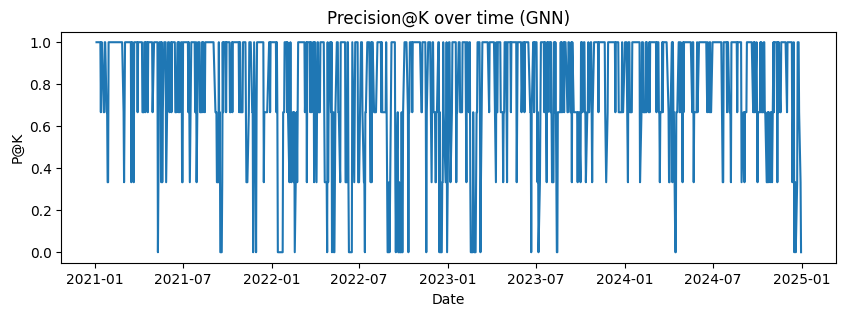

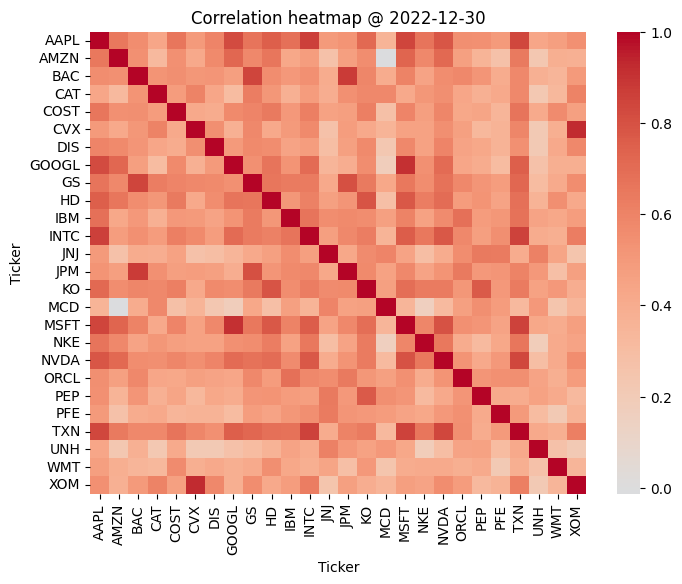

In [26]:
# Precision@K over time (GNN)
p_at_k_series = test_df.groupby('date').apply(
    lambda sub: precision_at_k(sub['score'].values, sub['label'].values, _resolve_k(len(sub)))
).sort_index()
plt.figure(figsize=(10,3))
plt.plot(p_at_k_series.index, p_at_k_series.values)
plt.title("Precision@K over time (GNN)")
plt.ylabel("P@K"); plt.xlabel("Date"); plt.show()

# Correlation heatmap (sample day)
import seaborn as sns
sample_day = test_dates_available[len(test_dates_available)//2]
end_loc = returns_1d.index.get_loc(sample_day)
window = returns_1d.iloc[end_loc-CONFIG["corr_window"]+1:end_loc+1][tickers_used]
corr = window.corr().fillna(0.0)
plt.figure(figsize=(8,6)); sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title(f"Correlation heatmap @ {sample_day.date()}"); plt.show()
